# Inspect a model's performance on a larger dataset to get an idea of performance in production
So far to train models, we have used a validation set which is small, and contains a few hundred examples per class, with equal numbers of examples in each class. 

In reality there will likely be far more absent examples than present examples. We can run our model on the full validation set, which has been partially cleaned using a top-down cleaning approach, since there are too many clips to check manually. 

This was carried out in notebook 4. 

The larger validation set contains 8571 absent samples and 687 present samples. The present samples were all checked, and the absent samples were sorted by highest error between prediction and label (loss), then the top few hundred of these were checked, until the model predictions were below 80% and there were relatively few actual present samples. A confidence category was assigned to these so that they can be re-labelled. This dataset is saved as __valid_set_verified__

In [1]:
# imports
from pathlib import Path
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import opensoundscape as opso
from opensoundscape import Audio, audio
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import show_sample_from_df, show_samples_in_df, inspect_input_samples, get_binary_targets_scores, suppress_warnings_if_main_branch, clean_confidence_cats, plot_metrics_across_thresholds, verify_samples, clean_confidence_cats

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
suppress_warnings_if_main_branch()

%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
# load the validation data
data_path = Path.cwd().parent.parent / "data"
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_set_verified.pkl")
# Load the validation set of absent samples from locations outside of the target species' habitat
other_habitats = pd.read_pickle(data_path / "interim" / "valid_set" / "other_habitat_valid.pkl")

there are examples which need re-labelling. The function clean_confidence_cats will help with this:

In [60]:
def clean_confidence_cats(df, drop_unchecked=False):
    # Re-label the mis-labelled clips
    df.loc[df["confidence_cat"] == 5, "target_present"] = 1.0
    df.loc[df["confidence_cat"] == 6, "target_present"] = 0.0

    # drop the clips with confidence 1 or 2 since these were hard label.
    df = df[df["confidence_cat"] != 1]
    df = df[df["confidence_cat"] != 2]
    if drop_unchecked:
        # Drop the unverified clips
        df = df[df["confidence_cat"] != 0]
    return df

In [62]:
valid_df = clean_confidence_cats(valid_df)
valid_ds = valid_df[["target_present"]]

# Load a saved model

In [6]:
model = opso.load_model(model_save_path / "ancient-frog-200.model")

# Make predictions with the model

In [7]:
predictions = model.predict(valid_ds, batch_size=64, num_workers=4, activation_layer='sigmoid')

  0%|          | 0/142 [00:00<?, ?it/s]

In [63]:
valid_df['predicted'] = predictions.target_present

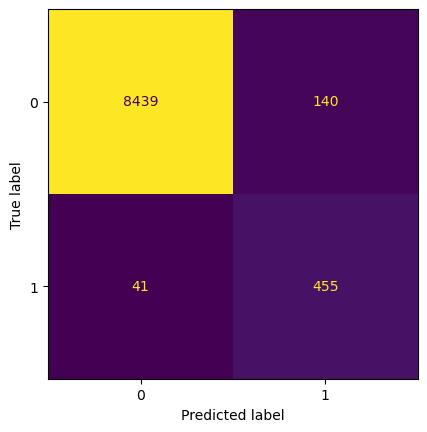

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.plot_confusion_matrix(threshold=0.5)>

In [64]:
def plot_confusion_matrix(threshold=0.5):
    preds, targets, scores = get_binary_targets_scores(valid_df, predictions, threshold)
    # plot confusion matrix
    cm = confusion_matrix(targets, preds)
    _ = ConfusionMatrixDisplay(cm).plot(colorbar=False)
    return cm
cm = plot_confusion_matrix(threshold=0.5)
interact(plot_confusion_matrix, threshold=(0.0, 1.0, 0.01))

# Plot metrics across thresholds

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


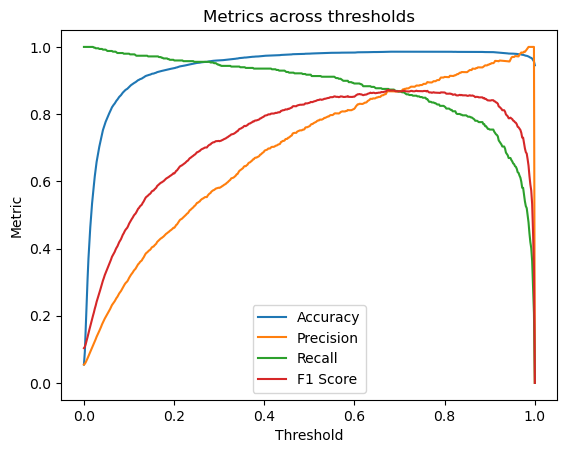

In [65]:
plot_data, legend = plot_metrics_across_thresholds(valid_df, 'predicted', 'target_present')
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

# Collect the errors

In [66]:
false_positives = valid_df.loc[valid_df['predicted'] > 0.8].loc[valid_df['target_present'] == 0.0]
false_negatives = valid_df.loc[valid_df['predicted'] < 0.8].loc[valid_df['target_present'] == 1.0]
len(false_positives), len(false_negatives)

(40, 88)

# Show the false negatives
This is a sample of the 88 examples which our model missed when the threshold was set to 0.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

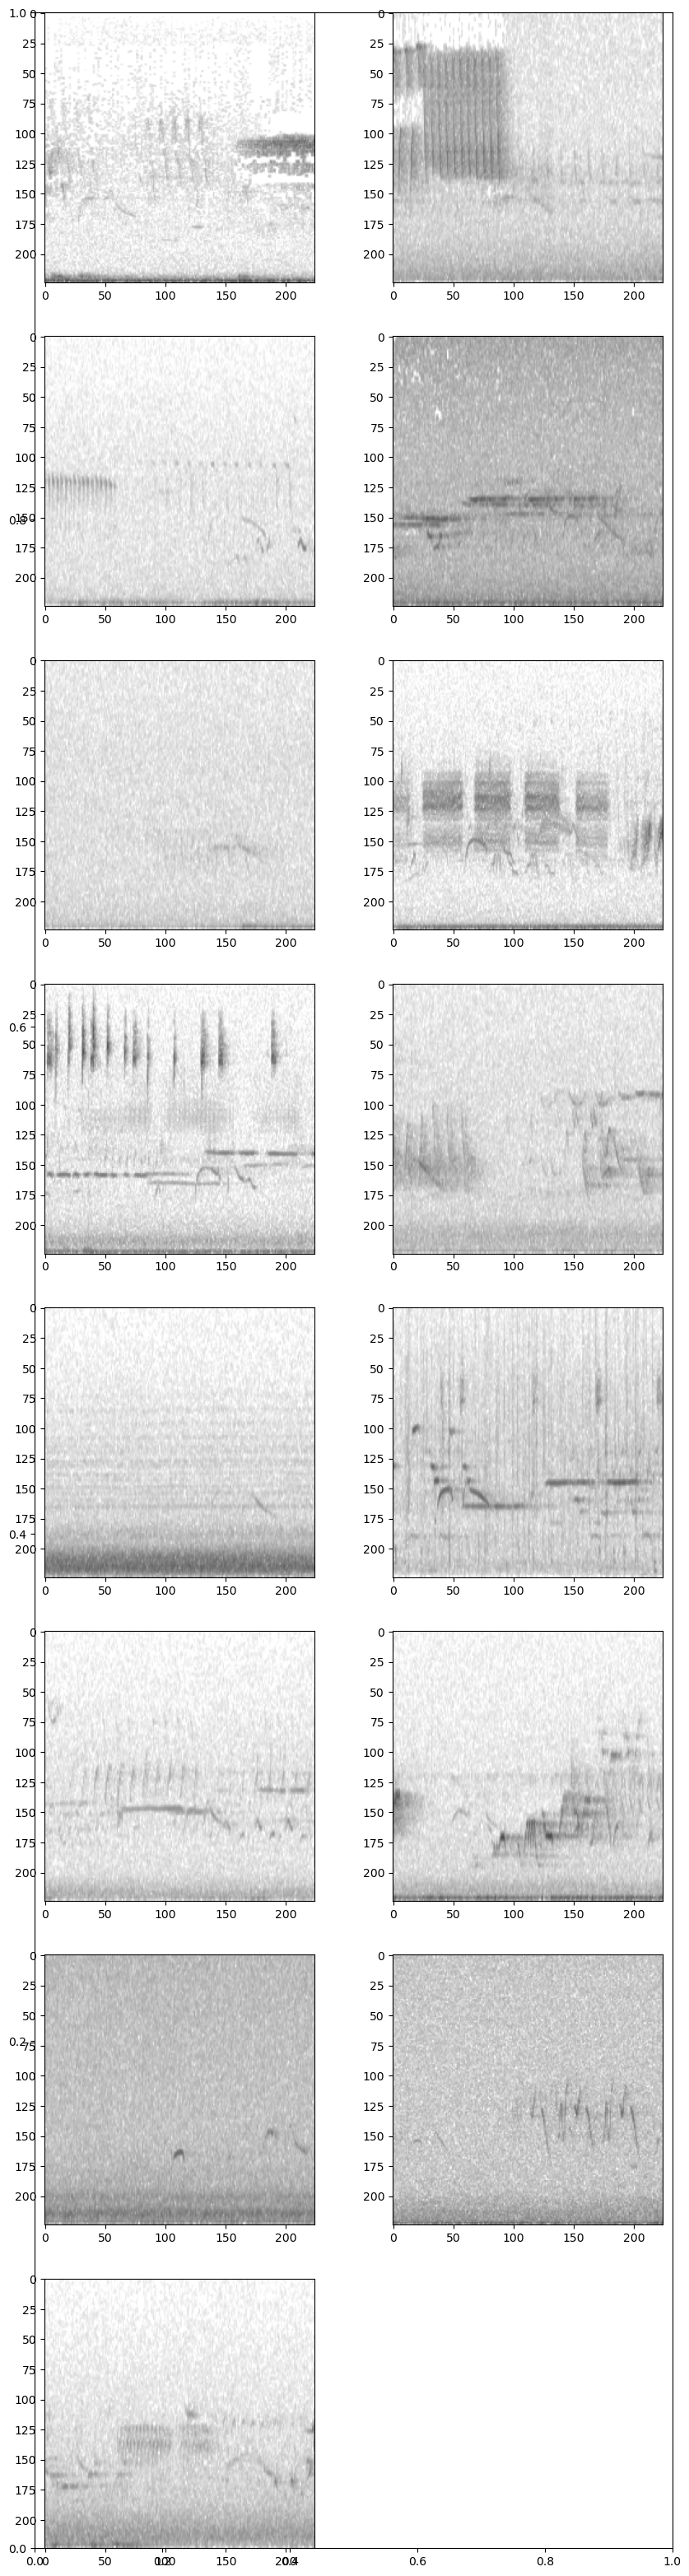

In [67]:
show_samples_in_df(false_negatives.sample(15), model)

# Show the false positives
This is a sample from the 40 negative examples our model identified as positives when the threshold was set to 0.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

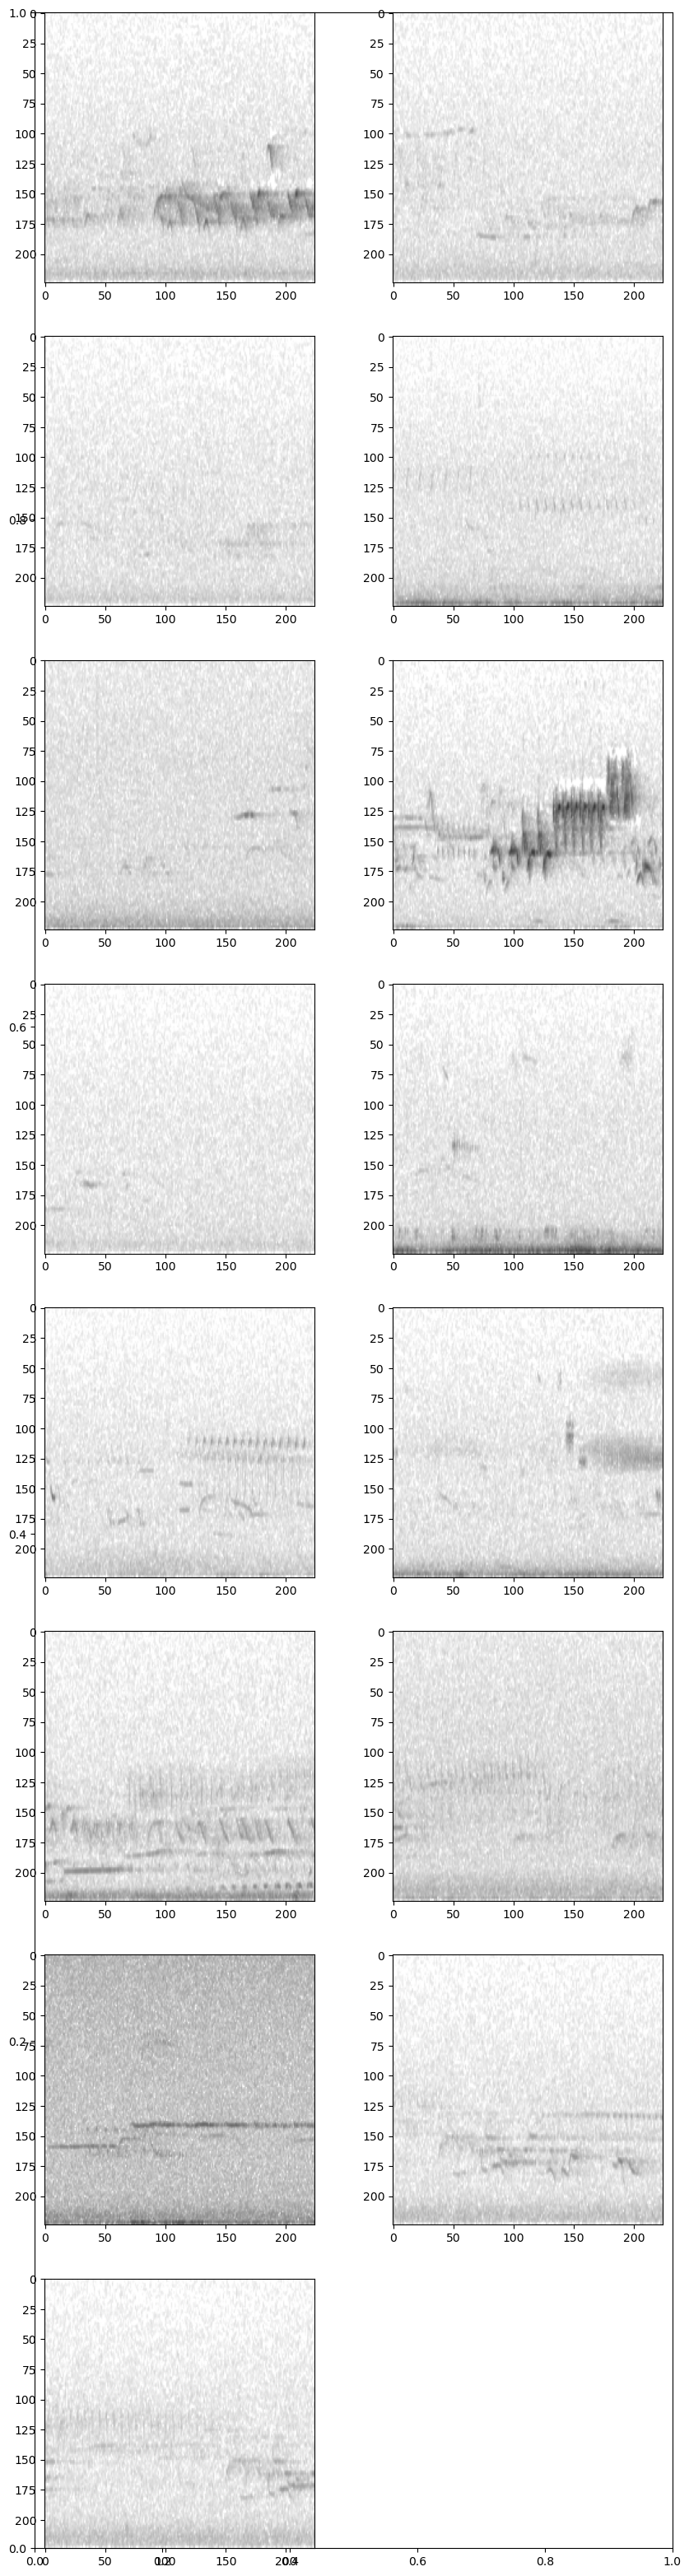

In [69]:
show_samples_in_df(false_positives.sample(15), model)

# Other habitat audio
We made a dataset of audio from outside the target species habitat. We can use this to get an idea of how many additional false positives are likely to show up if the model is used in new areas.

Make predictions on a set of samples from outside the target habitat

In [70]:
other_habitats_preds = model.predict(other_habitats[['target_present']], batch_size=64, num_workers=4, activation_layer='sigmoid')

  0%|          | 0/8 [00:00<?, ?it/s]

In [71]:
sum(other_habitats_preds.target_present < 0.8), sum(other_habitats_preds.target_present < 0.5)

(499, 482)

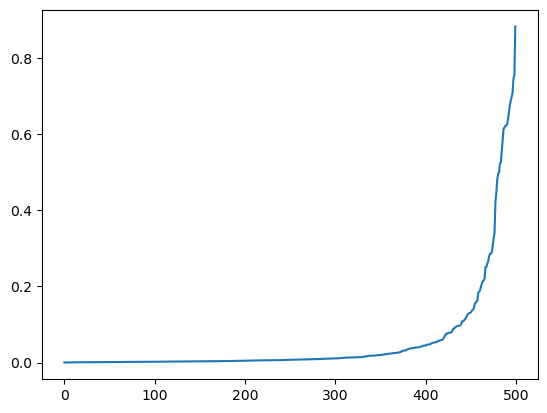

In [72]:
# Show the distribution of the 500 predictions. 
plt.plot(sorted(other_habitats_preds.target_present.values))

The number of false positives found in the other habitats recordings is promising, especially since half of the values in this training set are intentionally picked from the highest errors returned by a previous model.

# Comparison between models can be tricky. It's necessary to use the same test data to evaluate different models.

To compare the models with others such as Birdnet, HawkEars, Perch etc, we can export the 3 second segments of audio to disk then run another model on these clips. 

# Ennumerate each clip in the dataset

In [84]:
# Add an index to the validation clips to use as a file ID
valid_df.loc[:, 'file_ID'] = range(0, len(valid_ds))
valid_df.loc[:, 'file_ID'] = valid_ds['file_ID'].astype(int)
valid_df.head()

recording_url  \
file                                              start_time end_time                                                      
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  1.5        4.5       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  3.0        6.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  4.5        7.5       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   
                                                  6.0        9.0       https://wildtrax-aru.s3.us-west-2.amazonaws.co...   

                                                                      task_method  \
file                                              start_time end_time               
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0             1SPM   
                                                  1.5        4.5             1SPM   
                                                  3.0        6.0             1SPM   
                                                  4.5        7.5             1SPM   
                                                  6.0        9.0             1SPM   

                                                                                                   project  \
file                                              start_time end_time                                        
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0       Boreal Wetland Community Monitoring   
                                                  1.5        4.5       Boreal Wetland Community Monitoring   
                                                  3.0        6.0       Boreal Wetland Community Monitoring   
                                                  4.5        7.5       Boreal Wetland Community Monitoring   
                                                  6.0        9.0       Boreal Wetland Community Monitoring   

                                                                         detection_time  \
file                                              start_time end_time                     
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0       [106.56, 122.66]   
                                                  1.5        4.5       [106.56, 122.66]   
                                                  3.0        6.0       [106.56, 122.66]   
                                                  4.5        7.5       [106.56, 122.66]   
                                                  6.0        9.0       [106.56, 122.66]   

                                                                      tag_duration  \
file                                              start_time end_time                
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0       [1.0, 0.84]   
                                                  1.5        4.5       [1.0, 0.84]   
                                                  3.0        6.0       [1.0, 0.84]   
                                                  4.5        7.5       [1.0, 0.84]   
                                                  6.0        9.0       [1.0, 0.84]   

                                                                        latitude  \
file                                              start_time end_time              
../../data/raw/recordings/OSFL/recording-4427.mp3 0.0        3.0       57.302163   
                                                  1.5        4.5       57.302163   
                                                  3.0        6.0       57.302163   
                                                  4.5        7.5       57.302163   
                                                  6.0        9.0       57.302163   

                                         

In [82]:
# Make a path to save the clips to
save_path = data_path / "processed" / "validation_set" / "clips"
Path.mkdir(save_path, exist_ok=True, parents=True)

In [83]:
def save_dataframe_clips_to_disk(df, save_path):
    '''
    function for saving the 3 second clips which make up a dataset to disk. 
    filename contains a numeric index and the file extension.
    args:
    df: pandas dataframe with column ['file_ID'] containing unique numeric index per clip
    '''
    i=0
    for index in df.index:
        path, start, end = index
        row_id = int(df.iloc[i].file_ID)        
        clip = audio.Audio.from_file(path, offset=start, duration=end-start)
        extension = str(path).split('.')[-1]
        clip.save(save_path / f"{str(row_id)}.{extension}", suppress_warnings=True)
        i += 1

save_dataframe_clips_to_disk(valid_df, save_path)

In [89]:
# Save the validation metadata in the same place
valid_df.to_pickle(save_path.parent / "validation_set.pkl")

# Make predictions on these clips using an existing model then parse the results

Comparison could be made with BirdNet, Perch etc, but I've chosen to compare to HawkEars since I believe it to be the best available model for this species in this region. 

Predictions are made locally by cloning the hawkears repository and running the following lines in the terminal from the root of the hawkears repository:

``` 
python3 analyze.py -i <path to input clips> -o <path to output results>
```

The output path was chosen as the parent folder of the audio clips. 

In [100]:
predictions_path = save_path.parent

In [107]:
hawkears_files = glob.glob(str(predictions_path / '*.txt'))

In [104]:
def hawkears_files_to_df(hawkears_output_files, target_species="OSFL"):
    '''
    Takes a list of file paths containing hawkears predictions. 
    Predictions should be made on 3 second audio files saved to disk. 
    Returns a dataframe of predictions per file. 
    '''
    results = []
    # Read and parse the file contents
    for file_path in hawkears_output_files:
        with open(file_path, 'r') as f:
            file_content = f.read().strip().split('\n')
            file_id = file_path.split('/')[-1].split('-')[0]
            file_id = file_id.split('_')[0]
            for detection in file_content:
                if detection:
                    line = [file_id] + detection.split('\t')
                else:
                    line=[file_id]
                results.append(line)     

    # Convert the results to a pandas DataFrame
    df = pd.DataFrame(results, columns=['file_id', 'start_time', 'end_time', 'species;confidence'])
    df.file_id = df.file_id.astype(int)
    df.sort_values(by=['file_id'], inplace=True)
    df[['species', 'confidence']] = df['species;confidence'].str.split(';', expand=True)
    df.drop(columns=['species;confidence'], inplace=True)
    df = df.loc[df['species'] == target_species]
    df.confidence = df.confidence.astype(float)
    return df.reset_index(drop=True)

In [108]:
hawkears_df = hawkears_files_to_df(hawkears_files)

In [95]:
hawkears_df.rename(columns={"confidence": "target_present"}, inplace=True)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_39228/3303052366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osfls.rename(columns={"confidence": "target_present"}, inplace=True)


In [94]:
def plot_confusion_matrix(threshold=0.5):
    preds, targets, scores = get_binary_targets_scores(valid_df, osfls, threshold)
    # plot confusion matrix
    cm = confusion_matrix(targets, preds)
    _ = ConfusionMatrixDisplay(cm).plot(colorbar=False)
    return cm
cm = plot_confusion_matrix(threshold=0.5)
interact(plot_confusion_matrix, threshold=(0.0, 1.0, 0.01))

ValueError: Found input variables with inconsistent numbers of samples: [9075, 9074]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-

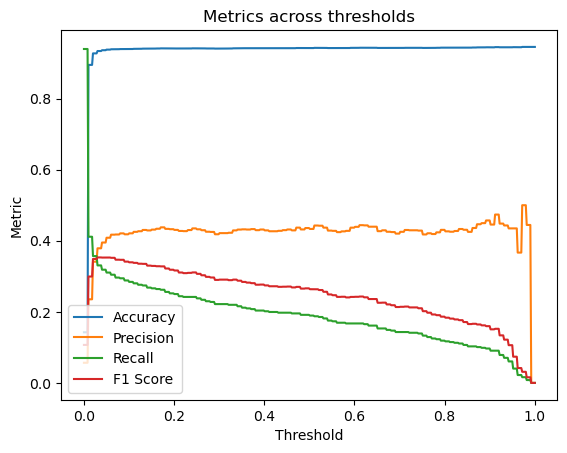

In [58]:
plot_data, legend = plot_metrics_across_thresholds(df, 'hawkears_prediction', 'target_present')
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))